In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [41]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.cm
from utils import Trade, Resources, Goal
from collections import defaultdict

In [29]:
exp_path = "../.logs/1698480633466"
# exp_path = "../.logs/1698477062823"
with open(os.path.join(exp_path,"state.json")) as f:
    exp_state = json.load(f)

In [36]:
def load_states(paths):
    states = {}
    for exp_path in paths:
        with open(os.path.join(exp_path,"state.json")) as f:
            states[exp_path] = json.load(f)
    return states

In [64]:
def compute_agent_proposal_utility(exp_state):
    proposal_utility = defaultdict(list)
    for agent_id, agent_state in enumerate(exp_state):
        # print("Agent {}".format(agent_id))
        for state in agent_state[1:]:
            if state['proposed_trade'] != "None":
                # convert string into objects
                resources = Resources.from_string(state['resources'])
                goals = Goal.from_string(state['goals'])
                proposed_trade = Trade.from_string(state['proposed_trade'])
                # mini hack to get the right sign
                marginal_utility = goals-resources if agent_id == 0 else resources-goals
                proposal_utility[agent_id].append(proposed_trade.utility(marginal_utility))
    return proposal_utility

def compute_agent_success(exp_state):
    success = defaultdict(bool)
    for agent_id, agent_state in enumerate(exp_state):
        # print("Agent {}".format(agent_id))
        state = agent_state[-1]
        goals = Goal.from_string(state['goals'])
        resources = Resources.from_string(state['resources'])
        goal_reached = goals.goal_reached(resources)
        success[agent_id] = goal_reached
    return success



In [65]:
paths = [
    "../.logs/1698480633466",
    "../.logs/1698477062823",
    "../.logs/1698481270492",
    "../.logs/1698481933477",
    "../.logs/1698482232830"
]
states = load_states(paths)

In [66]:
utilities = [compute_agent_proposal_utility(_) for _ in states.values()]
success = [compute_agent_success(_) for _ in states.values()]

In [67]:
success

[defaultdict(bool, {0: False, 1: False}),
 defaultdict(bool, {0: True, 1: True}),
 defaultdict(bool, {0: True, 1: False}),
 defaultdict(bool, {0: True, 1: True}),
 defaultdict(bool, {0: False, 1: False})]

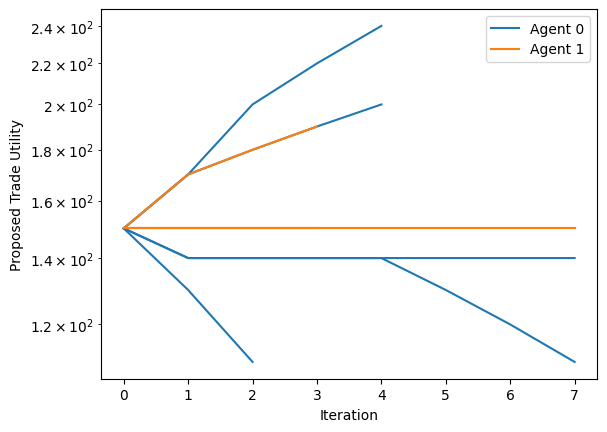

In [61]:
color = matplotlib.cm.datad['tab10']['listed']
for util in utilities:
    for idx, _ in enumerate(util.values()):
        plt.plot(_, color=color[idx])

plt.legend(['Agent 0', 'Agent 1'])
plt.xlabel('Iteration')
plt.ylabel('Proposed Trade Utility')
plt.yscale('log')